# 02. Neural Network Classification with TensorFlow

Okay, we've seen how to deal with a regression problem in TensorFlow, let's look at how we can approach a classification problem.

A [classification problem](https://en.wikipedia.org/wiki/Statistical_classification) involves predicting whether something is one thing or another.

For example, you might want to:
* Predict whether or not someone has heart disease based on their health parameters. This is called **binary classification** since there are only two options.
* Decide whether a photo of is of food, a person or a dog. This is called **multi-class classification** since there are more than two options.
* Predict what categories should be assigned to a Wikipedia article. This is called **multi-label classification** since a single article could have more than one category assigned.

In this notebook, we're going to work through a number of different classification problems with TensorFlow. In other words, taking a set of inputs and predicting what class those set of inputs belong to.

## What we're going to cover

Specifically, we're going to go through doing the following with TensorFlow:
- Architecture of a classification model
- Input shapes and output shapes
  - `X`: features/data (inputs)
  - `y`: labels (outputs) 
    - "What class do the inputs belong to?"
- Creating custom data to view and fit
- Steps in modelling for binary and mutliclass classification
  - Creating a model
  - Compiling a model
    - Defining a loss function
    - Setting up an optimizer
      - Finding the best learning rate
    - Creating evaluation metrics
  - Fitting a model (getting it to find patterns in our data)
  - Improving a model
- The power of non-linearity
- Evaluating classification models
  - Visualizng the model ("visualize, visualize, visualize")
  - Looking at training curves
  - Compare predictions to ground truth (using our evaluation metrics)

## How you can use this notebook

You can read through the descriptions and the code (it should all run, except for the cells which error on purpose), but there's a better option.

Write all of the code yourself.

Yes. I'm serious. Create a new notebook, and rewrite each line by yourself. Investigate it, see if you can break it, why does it break?

You don't have to write the text descriptions but writing the code yourself is a great way to get hands-on experience.

Don't worry if you make mistakes, we all do. The way to get better and make less mistakes is to **write more code**.

## Typical architecture of a classification neural network 

The word *typical* is on purpose.

Because the architecture of a classification neural network can widely vary depending on the problem you're working on.

However, there are some fundamentals all deep neural networks contain:
* An input layer.
* Some hidden layers.
* An output layer.

Much of the rest is up to the data analyst creating the model.

The following are some standard values you'll often use in your classification neural networks.

| **Hyperparameter** | **Binary Classification** | **Multiclass classification** |
| --- | --- | --- |
| Input layer shape | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
| Hidden layer(s) | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| Neurons per hidden layer | Problem specific, generally 10 to 100 | Same as binary classification |
| Output layer shape | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
| Hidden activation | Usually [ReLU](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) (rectified linear unit) | Same as binary classification |
| Output activation | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) | [Softmax](https://en.wikipedia.org/wiki/Softmax_function) |
| Loss function | [Cross entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`tf.keras.losses.BinaryCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) in TensorFlow) | Cross entropy ([`tf.keras.losses.CategoricalCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) in TensorFlow) |
| Optimizer | [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) | Same as binary classification |

***Table 1:*** *Typical architecture of a classification network.* ***Source:*** *Adapted from page 295 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)*

Don't worry if not much of the above makes sense right now, we'll get plenty of experience as we go through this notebook.

Let's start by importing TensorFlow as the common alias `tf`. For this notebook, make sure you're using version 2.x+.

In [1]:
 from sklearn.datasets import make_circles

 # Make 1000 examples
 n_samples = 1000

 # Create circles
 X, y = make_circles(n_samples,
                     noise=0.03,
                     random_state=42)

In [2]:
# Checkout features
X[:10]

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       [-0.39373073,  0.69288277],
       [ 0.44220765, -0.89672343],
       [-0.47964637,  0.67643477],
       [-0.01364836,  0.80334872],
       [ 0.77151327,  0.14775959],
       [-0.16932234, -0.79345575],
       [-0.1214858 ,  1.02150905]])

In [3]:
# Check the labels
y[:10]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0])

Okay, we've seen some of our data and labels, how about we move towards visualizing?

> 🔑 **Note:** One important step of starting any kind of machine learning project is to [become one with the data](https://karpathy.github.io/2019/04/25/recipe/). And one of the best ways to do this is to visualize the data you're working with as much as possible. The data explorer's motto is "visualize, visualize, visualize".

We'll start with a DataFrame.

In [4]:
import pandas as pd
circles = pd.DataFrame({"X0":X[:, 0], "X1":X[:, 1], "label": y})
circles.head(10)

,X0,X1,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


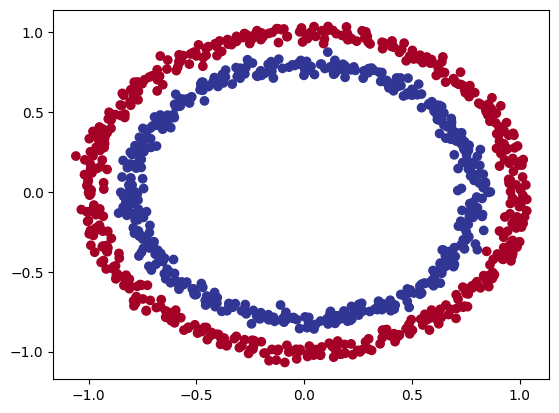

In [5]:
# Visalize with the plot
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

Nice! From the plot, can you guess what kind of model we might want to build?

How about we try and build one to classify blue or red dots? As in, a model which is able to distinguish blue from red dots.

> 🛠 **Practice:** Before pushing forward, you might want to spend 10 minutes playing around with the [TensorFlow Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=2,2&seed=0.93799&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&batchSize_hide=true). Try adjusting the different hyperparameters you see and click play to see a neural network train. I think you'll find the data very similar to what we've just created.

## Input and output shapes

One of the most common issues you'll run into when building neural networks is shape mismatches.

More specifically, the shape of the input data and the shape of the output data.

In our case, we want to input `X` and get our model to predict `y`.

So let's check out the shapes of `X` and `y`.

In [6]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# How many samples we are working with
len(X), len(y)

(1000, 1000)

In [8]:
# View the first wxample of features and labels
X[4], y[4]

(array([ 0.44220765, -0.89672343]), 0)

Alright, so we've got two `X` features which lead to one `y` value.

This means our neural network input shape will has to accept a tensor with at least one dimension being two and output a tensor with at least one value.

> 🤔 **Note:** `y` having a shape of (1000,) can seem confusing. However, this is because all `y` values are actually scalars (single values) and therefore don't have a dimension. For now, think of your output shape as being at least the same value as one example of `y` (in our case, the output from our neural network has to be at least one value).

## Steps in modelling

Now we know what data we have as well as the input and output shapes, let's see how we'd build a neural network to model it.

In TensorFlow, there are typically 3 fundamental steps to creating and training a model.

1. **Creating a model** - piece together the layers of a neural network yourself (using the [functional](https://www.tensorflow.org/guide/keras/functional) or [sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)) or import a previously built model (known as transfer learning).
2. **Compiling a model** - defining how a model's performance should be measured (loss/metrics) as well as defining how it should improve (optimizer). 
3. **Fitting a model** - letting the model try to find patterns in the data (how does `X` get to `y`). 
4. **Tweak** the model
5. **Evaluate the model**

Let's see these in action using the Sequential API to build a model for our regression data. And then we'll step through each.

In [9]:
# Import TensorFlow
import tensorflow as tf
tf.__version__

'2.12.0'

In [10]:
# Set the random seed
tf.random.set_seed(42)

# 1. Create the model using the Sequential API
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.SGD(),
                metrics=["accuracy"]) # see evaluatio metrics: https://www.ritchieng.com/machine-learning-evaluate-classification-model/

# 3. Fit the model
model_1.fit(X, y, epochs=5)

Epoch 1/5
32/32 [==============================] - 7s 3ms/step - loss: 3.0676 - accuracy: 0.4750
Epoch 2/5
32/32 [==============================] - 0s 3ms/step - loss: 0.7480 - accuracy: 0.4910
Epoch 3/5
32/32 [==============================] - 0s 3ms/step - loss: 0.7092 - accuracy: 0.4930
Epoch 4/5
32/32 [==============================] - 0s 3ms/step - loss: 0.6988 - accuracy: 0.4960
Epoch 5/5
32/32 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.4980


In [11]:
# Let's try and improve our model by training for longer...
model_1.fit(X, y, epochs=200, verbose=0)
model_1.evaluate(X, y)

32/32 [==============================] - 0s 2ms/step - loss: 0.6935 - accuracy: 0.5000


[0.6934829950332642, 0.5]

Even after 200 passes of the data, it's still performing as if it's guessing.

What if we added an extra layer and trained for a little longer?

In [12]:
# Set the random seed
tf.random.set_seed(42)

# 1. Create a model, this time with 2 layers
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(1),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.SGD(),
                metrics=["accuracy"])

# 3. Fit the model
model_2.fit(X, y, epochs=100, verbose=0)

In [13]:
model_2.evaluate(X, y)

32/32 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.5000


[0.6932628154754639, 0.5]

In [14]:
circles["label"].value_counts()

1    500
0    500
Name: label, dtype: int64

## Improving a model

To improve our model, we can alter almost every part of the 3 steps we went through before.

1. **Creating a model** - here you might want to add more layers, increase the number of hidden units (also called neurons) within each layer, change the activation functions of each layer.
2. **Compiling a model** - you might want to choose a different optimization function (such as the [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) optimizer, which is usually pretty good for many problems) or perhaps change the learning rate of the optimization function.
3. **Fitting a model** - perhaps you could fit a model for more epochs (leave it training for longer).

![various options you can use to improve a neural network model](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-improving-a-model-from-model-perspective.png)
*There are many different ways to potentially improve a neural network. Some of the most common include: increasing the number of layers (making the network deeper), increasing the number of hidden units (making the network wider) and changing the learning rate. Because these values are all human-changeable, they're referred to as [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)) and the practice of trying to find the best hyperparameters is referred to as [hyperparameter tuning](https://en.wikipedia.org/wiki/Hyperparameter_optimization).*

How about we try adding more neurons, an extra layer and our friend the Adam optimizer?

Surely doing this will result in predictions better than guessing...

> **Note:** The following message (below this one) can be ignored if you're running TensorFlow 2.8.0+, the error seems to have been fixed.

> **Note:** If you're using TensorFlow 2.7.0+ (but not 2.8.0+) the original code from the following cells may have caused some errors. They've since been updated to fix those errors. You can see explanations on what happened at the following resources:
* [Example Colab Notebook](https://colab.research.google.com/drive/1_dlrB_DJOBS9c9foYJs49I0YwN7LTakl?usp=sharing)
* [TensorFlow for Deep Learning GitHub Discussion on TensorFlow 2.7.0 breaking changes](https://github.com/mrdbourke/tensorflow-deep-learning/discussions/278)


In [15]:
# Set the random seed
tf.random.set_seed(42)

# 1. Create a model
model_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(100), # add 100 dense neurons
  tf.keras.layers.Dense(10), # add another layer with 10 neurons
  tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 3. Fit the model
model_3.fit(X, y, epochs=100, verbose=0)

In [16]:
model_3.evaluate(X, y)

32/32 [==============================] - 0s 2ms/step - loss: 0.6962 - accuracy: 0.5090


[0.6961713433265686, 0.5090000033378601]

In [17]:
model_3.predict(X)

32/32 [==============================] - 0s 1ms/step


array([[0.48725155],
       [0.5499703 ],
       [0.5533245 ],
       [0.55509704],
       [0.45713165],
       [0.5581998 ],
       [0.5428308 ],
       [0.4832568 ],
       [0.48775223],
       [0.555976  ],
       [0.5180088 ],
       [0.51905197],
       [0.5484485 ],
       [0.46625587],
       [0.46221027],
       [0.47326472],
       [0.5386002 ],
       [0.47573516],
       [0.5428288 ],
       [0.510195  ],
       [0.50126475],
       [0.5686664 ],
       [0.47345063],
       [0.48969802],
       [0.5684012 ],
       [0.5596313 ],
       [0.536593  ],
       [0.46920928],
       [0.47022036],
       [0.46446088],
       [0.48980156],
       [0.55933344],
       [0.54110426],
       [0.4678518 ],
       [0.47365215],
       [0.5720661 ],
       [0.5579565 ],
       [0.5192837 ],
       [0.4708213 ],
       [0.50352216],
       [0.5071285 ],
       [0.5316719 ],
       [0.5158982 ],
       [0.46548292],
       [0.5248929 ],
       [0.53719825],
       [0.46189597],
       [0.531

Now we've got a function to plot our model's decision boundary (the cut off point its making between red and blue dots), let's try it out.

Still! 

We've pulled out a few tricks but our model isn't even doing better than guessing.

Let's make some visualizations to see what's happening.

> 🔑 **Note:** Whenever your model is performing strangely or there's something going on with your data you're not quite sure of, remember these three words: **visualize, visualize, visualize**. Inspect your data, inspect your model, inpsect your model's predictions.

To visualize our model's predictions we're going to create a function `plot_decision_boundary()` which:
* Takes in a trained model, features (`X`) and labels (`y`).
* Creates a [meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html) of the different `X` values.
* Makes predictions across the meshgrid.
* Plots the predictions as well as a line between the different zones (where each unique class falls).

If this sounds confusing, let's see it in code and then see the output.

> 🔑 **Note:** If you're ever unsure of what a function does, try unraveling it and writing it line by line for yourself to see what it does. Break it into small parts and see what each part outputs.

In [18]:
# Import NumPy
import numpy as np

In [19]:
def plot_decision_boundry(model, X, y):
  """
  Plots the decision boundary created by a model predicting on X.
  This function has been adapted from two phenomenal resources:
   1. CS231n - https://cs231n.github.io/neural-networks-case-study/
   2. Made with ML basics - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
  """
  # Define the axis boundries of the plot and create a meshgird
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 1].max() + 0.1
  y_min, y_max = X[:, 0].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))
  
  # Create X value (we are going to make prediction on these)
  x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together

  # Make predictions 
  y_pred = model.predict(x_in)

  # Check for multi-class
  if len(y_pred[0]) > 1:
    print("Doing multi-class classification")
    # We have to reshape our prediction to get them ready fpr plotting
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
  else:
    print("Doing Binary classification")
    y_pred = np.round(y_pred).reshape(xx.shape)

  # Plot the decision boundry
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

313/313 [==============================] - 0s 1ms/step
Doing Binary classification


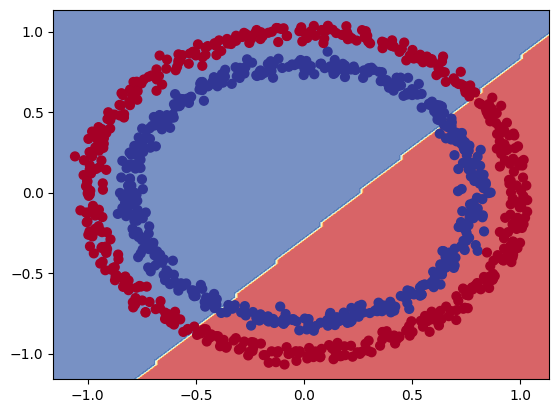

In [20]:
# Check ou tthe predictions our model is making
plot_decision_boundry(model=model_3,
                      X=X,
                      y=y)

In [21]:
# Set the random seed
tf.random.set_seed(42)

# 1. Create a model
model_4 = tf.keras.Sequential([
  tf.keras.layers.Dense(100, activation="relu"), # add 100 dense neurons
  tf.keras.layers.Dense(10, activation="relu"), # add another layer with 10 neurons
  tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 3. Fit the model
model_4.fit(X, y, epochs=100, verbose=0)

In [22]:
model_4.evaluate(X, y)

32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 1.0000


[0.003558845492079854, 1.0]

313/313 [==============================] - 0s 1ms/step
Doing Binary classification


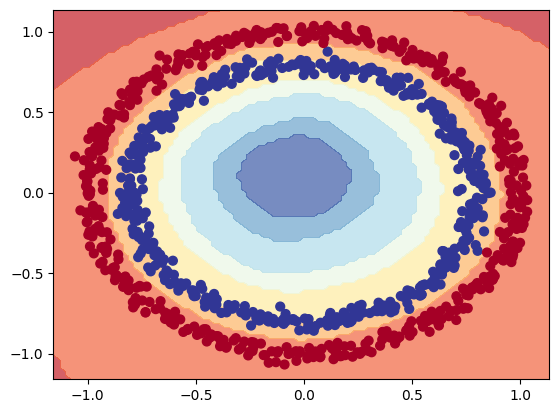

In [23]:
# Check ou tthe predictions our model is making
plot_decision_boundry(model=model_4,
                      X=X,
                      y=y)

Looks like our model_3 is trying to draw a straight line through the data.

What's wrong with doing this?

The main issue is our data isn't separable by a straight line.

In a regression problem, our model might work. In fact, let's try it.

In [36]:
# Set random seed
tf.random.set_seed(42)

# Create some regression data
X_regression = np.arange(0, 1000, 5)
y_regression = np.arange(100, 1100, 5)

# Split it into training and test sets
X_reg_train = X_regression[:150]
X_reg_test = X_regression[150:]
y_reg_train = y_regression[:150]
y_reg_test = y_regression[150:]

# # Fit our model to the regression data
# model_3.fit(X_reg_train, y_reg_train, epochs=100)

Oh wait... we compiled our model for a binary classification problem.

No trouble, we can recreate it for a regression problem.

In [38]:
# Set random seed
tf.random.set_seed(42)

# 2. Create the model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_3.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

# 3. Fit the model
model_3.fit(tf.expand_dims(X_reg_train, axis=-1), 
            y_reg_train, 
            epochs=100)

Epoch 1/100
5/5 [==============================] - 1s 5ms/step - loss: 270.9083 - mae: 270.9083
Epoch 2/100
5/5 [==============================] - 0s 4ms/step - loss: 175.4004 - mae: 175.4004
Epoch 3/100
5/5 [==============================] - 0s 4ms/step - loss: 81.9577 - mae: 81.9577
Epoch 4/100
5/5 [==============================] - 0s 4ms/step - loss: 53.2931 - mae: 53.2931
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 70.4377 - mae: 70.4377
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 55.4438 - mae: 55.4438
Epoch 7/100
5/5 [==============================] - 0s 4ms/step - loss: 42.3604 - mae: 42.3604
Epoch 8/100
5/5 [==============================] - 0s 4ms/step - loss: 47.7963 - mae: 47.7963
Epoch 9/100
5/5 [==============================] - 0s 4ms/step - loss: 41.6569 - mae: 41.6569
Epoch 10/100
5/5 [==============================] - 0s 4ms/step - loss: 44.1304 - mae: 44.1304
Epoch 11/100
5/5 [==============================] - 0s 

2/2 [==============================] - 0s 3ms/step


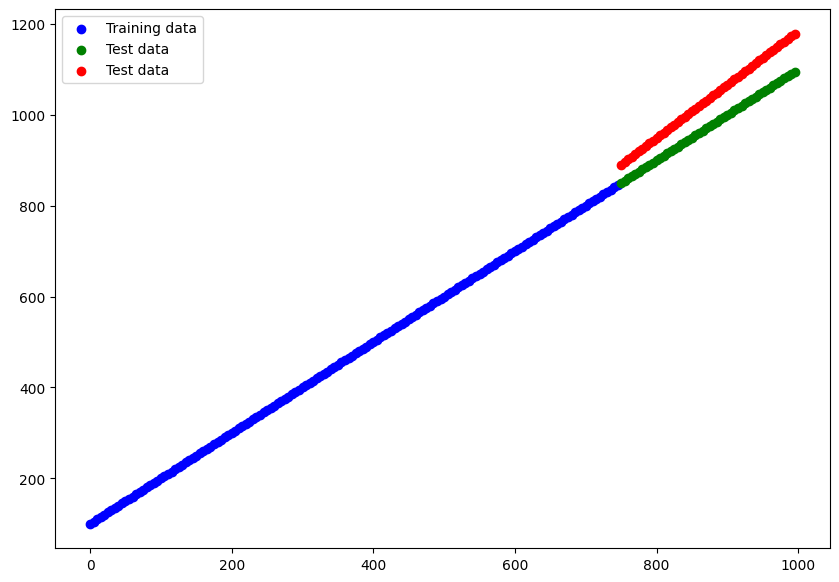

In [43]:
# Make prediction
y_reg_preds = model_3.predict(X_reg_test)

# Plot the model's prediction
plt.figure(figsize=(10, 7))
plt.scatter(X_reg_train, y_reg_train, c="b", label="Training data")
plt.scatter(X_reg_test, y_reg_test, c="g", label="Test data")
plt.scatter(X_reg_test, y_reg_preds, c="r", label="Test data")
plt.legend()

Okay, the predictions aren't perfect (if the predictions were perfect, the red would line up with the green), but they look better than complete guessing.

So this means our model must be learning something...

There must be something we're missing out on for our classification problem.

## The missing piece: Non-linearity

Okay, so we saw our neural network can model straight lines (with ability a little bit better than guessing).

What about non-straight (non-linear) lines?

If we're going to model our classification data (the red and clue circles), we're going to need some non-linear lines.

> 🔨 **Practice:** Before we get to the next steps, I'd encourage you to play around with the [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=1&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.09561&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularizationRate_hide=true&discretize_hide=true&regularization_hide=true&dataset_hide=true&noise_hide=true&batchSize_hide=true) (check out what the data has in common with our own classification data) for 10-minutes. In particular the tab which says "activation". Once you're done, come back.

Did you try out the activation options? If so, what did you find?

If you didn't, don't worry, let's see it in code.

We're going to replicate the neural network you can see at this link: [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=1&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.09561&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularizationRate_hide=true&discretize_hide=true&regularization_hide=true&dataset_hide=true&noise_hide=true&batchSize_hide=true).

![simple neural net created with TensorFlow playground](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-tensorflow-playground-simple-net-linear-activation.png)
*The neural network we're going to recreate with TensorFlow code. See it live at [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=1&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.09561&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularizationRate_hide=true&discretize_hide=true&regularization_hide=true&dataset_hide=true&noise_hide=true&batchSize_hide=true).*

The main change we'll add to models we've built before is the use of the `activation` keyword.


In [44]:
# Set the random seed
tf.random.set_seed(42)

# 1. Create the model
model_4 = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation=tf.keras.activations.linear)])

# 2. Compile the model
model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 3. Fit the model
history = model_4.fit(X, y, epochs=100)

Epoch 1/100
32/32 [==============================] - 1s 3ms/step - loss: 5.8700 - accuracy: 0.4860
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 5.7986 - accuracy: 0.4830
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 5.7965 - accuracy: 0.4820
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 5.7787 - accuracy: 0.4830
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 5.7790 - accuracy: 0.4830
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 5.7785 - accuracy: 0.4830
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 5.7698 - accuracy: 0.4830
Epoch 8/100
32/32 [==============================] - 0s 3ms/step - loss: 5.7571 - accuracy: 0.4820
Epoch 9/100
32/32 [==============================] - 0s 4ms/step - loss: 5.7513 - accuracy: 0.4820
Epoch 10/100
32/32 [==============================] - 0s 3ms/step - loss: 5.7509 - accuracy: 0.4820
Epoch 11/

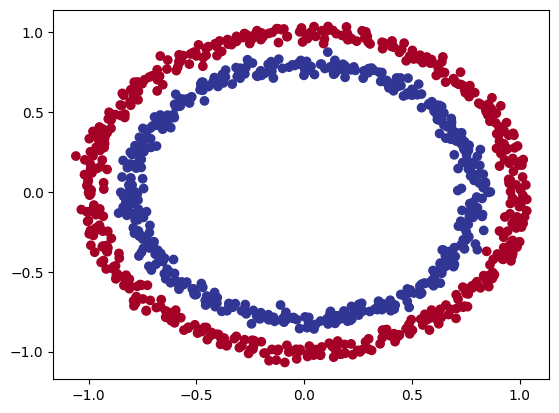

In [46]:
# Check out ourdata
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

313/313 [==============================] - 0s 1ms/step
Doing Binary classification


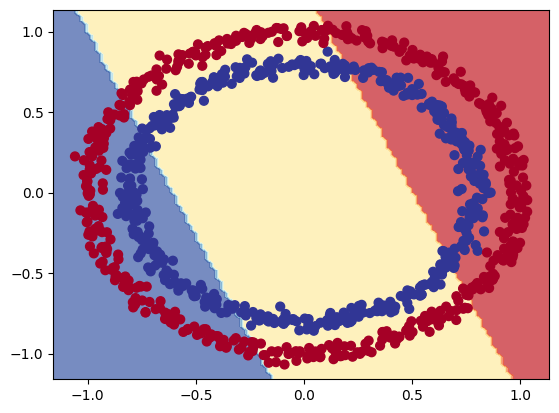

In [47]:
# Check the decision boundry for our latest model
plot_decision_boundry(model=model_4,
                      X=X,
                      y=y)

Well, it looks like we're getting a straight (linear) line prediction again. 

But our data is non-linear (not a straight line)...

What we're going to have to do is add some non-linearity to our model.

To do so, we'll use the `activation` parameter in on of our layers.


Activation function for NN:
https://www.v7labs.com/blog/neural-networks-activation-functions

In [77]:
# Set the random seed
tf.random.set_seed(42)

# 1. Create the model
model_5 = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1)])

# 2. Compile the model
model_5.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(lr=0.01),
                metrics=["accuracy"])

# 3. Fit the model
history = model_5.fit(X, y, epochs=100);

Epoch 1/100
32/32 [==============================] - 1s 4ms/step - loss: 2.9025 - accuracy: 0.5000
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 1.8219 - accuracy: 0.4920
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 1.0278 - accuracy: 0.4520
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8779 - accuracy: 0.4410
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8557 - accuracy: 0.4310
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8390 - accuracy: 0.4160
Epoch 7/100
32/32 [==============================] - 0s 5ms/step - loss: 0.8257 - accuracy: 0.4170
Epoch 8/100
32/32 [==============================] - 0s 5ms/step - loss: 0.8140 - accuracy: 0.4100
Epoch 9/100
32/32 [==============================] - 0s 5ms/step - loss: 0.8035 - accuracy: 0.4120
Epoch 10/100
32/32 [==============================] - 0s 4ms/step - loss: 0.7923 - accuracy: 0.4100
Epoch 11/

313/313 [==============================] - 0s 1ms/step
Doing Binary classification


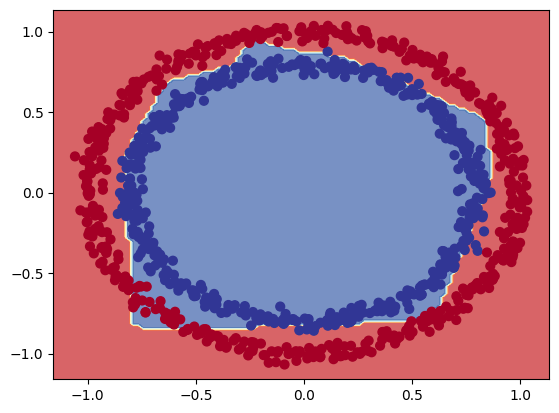

In [78]:
plot_decision_boundry(model=model_5,
                      X=X,
                      y=y)

In [92]:
# Time to replicate the multi-layer NN from tensorFlow

# Set random seed
tf.random.set_seed(42)

# 1. Create the model
model_6 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_6.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=["accuracy"])

# 3. Fit the model
history = model_6.fit(X, y, epochs=100)

Epoch 1/100
32/32 [==============================] - 1s 3ms/step - loss: 3.5509 - accuracy: 0.5000
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 2.0891 - accuracy: 0.5000
Epoch 3/100
32/32 [==============================] - 0s 4ms/step - loss: 1.0659 - accuracy: 0.5000
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 0.9820 - accuracy: 0.5000
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 0.9270 - accuracy: 0.5000
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8845 - accuracy: 0.5000
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8512 - accuracy: 0.5000
Epoch 8/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8246 - accuracy: 0.4990
Epoch 9/100
32/32 [==============================] - 0s 4ms/step - loss: 0.8039 - accuracy: 0.4890
Epoch 10/100
32/32 [==============================] - 0s 3ms/step - loss: 0.7868 - accuracy: 0.4820
Epoch 11/

313/313 [==============================] - 1s 2ms/step
Doing Binary classification


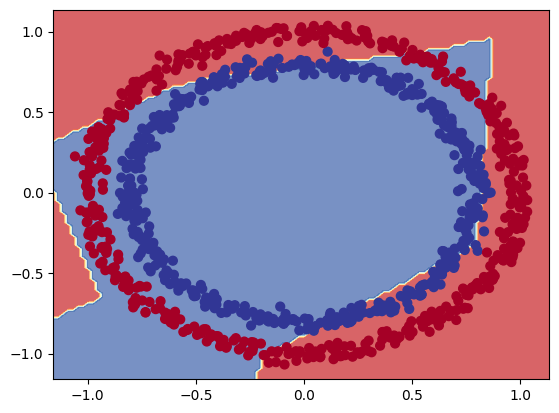

In [93]:
# plot decision boundry
plot_decision_boundry(model=model_6,
                      X=X,
                      y=y)

In [102]:
# Set the random seed
tf.random.set_seed(42)

# 1. Create the model
model_7 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(4, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid) # See useage of activation function: https://towardsdatascience.com/how-to-choose-the-right-activation-function-for-neural-networks-3941ff0e6f9c#:~:text=The%20output%20layer%20activation%20function,activation%20function%20with%20one%20node.
])

# 2. Compile the model
model_7.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                metrics=["accuracy"])

# 3. Fit the model
history = model_7.fit(X, y, epochs=100)

Epoch 1/100
32/32 [==============================] - 1s 4ms/step - loss: 0.6968 - accuracy: 0.4910
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 0.6910 - accuracy: 0.5010
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 0.6864 - accuracy: 0.5050
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 0.6799 - accuracy: 0.5530
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 0.6668 - accuracy: 0.5440
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 0.6515 - accuracy: 0.6360
Epoch 7/100
32/32 [==============================] - 0s 4ms/step - loss: 0.6235 - accuracy: 0.7020
Epoch 8/100
32/32 [==============================] - 0s 3ms/step - loss: 0.5801 - accuracy: 0.7210
Epoch 9/100
32/32 [==============================] - 0s 3ms/step - loss: 0.5363 - accuracy: 0.7720
Epoch 10/100
32/32 [==============================] - 0s 4ms/step - loss: 0.4983 - accuracy: 0.7850
Epoch 11/

In [103]:
# 4. evaluate the model
model_7.evaluate(X, y)

32/32 [==============================] - 0s 2ms/step - loss: 0.0240 - accuracy: 0.9940


[0.024006206542253494, 0.9940000176429749]

313/313 [==============================] - 1s 2ms/step
Doing Binary classification


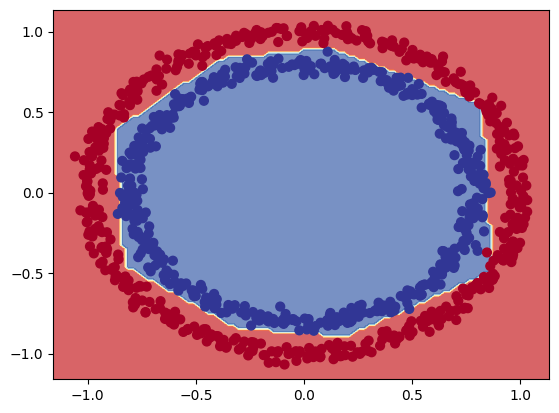

In [104]:
# Let's visualize out metrics
plot_decision_boundry(model=model_7,
                      X=X,
                      y=y)

See the link about using avtivation functions: 

https://towardsdatascience.com/how-to-choose-the-right-activation-function-for-neural-networks-3941ff0e6f9c#:~:text=The%20output%20layer%20activation%20function,activation%20function%20with%20one%20node.

Nice! It looks like our model is almost perfectly (apart from a few examples) separating the two circles.

> 🤔 **Question:** What's wrong with the predictions we've made? Are we really evaluating our model correctly here? Hint: what data did the model learn on and what did we predict on?

Before we answer that, it's important to recognize what we've just covered.

> 🔑 **Note:** The combination of **linear (straight lines) and non-linear (non-straight lines) functions** is one of the key fundamentals of neural networks.

Think of it like this:

If I gave you an unlimited amount of straight lines and non-straight lines, what kind of patterns could you draw?

That's essentially what neural networks do to find patterns in data.

Now you might be thinking, "but I haven't seen a linear function or a non-linear function before..."

Oh but you have.

We've been using them the whole time.

They're what power the layers in the models we just built.

To get some intuition about the activation functions we've just used, let's create them and then try them on some toy data.

In [110]:
# Create a toy tensor (similar to the data we pass into pur models)
A = tf.cast(tf.range(-10, 10), tf.float64)
A

<tf.Tensor: shape=(20,), dtype=float64, numpy=
array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])>

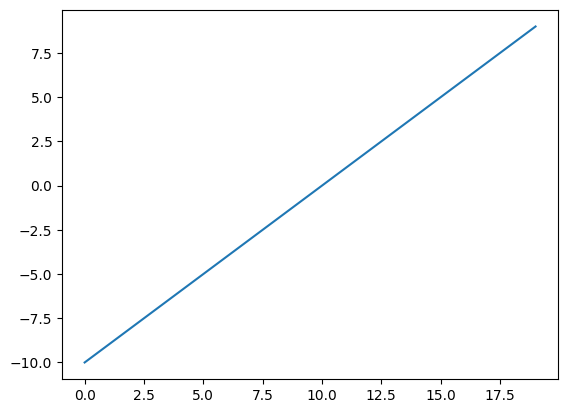

In [111]:
# visualize our toy tensor
plt.plot(A)

In [112]:
# Let's start by replicating sigmoid - sigmoid(x) = 1 / (1 + exp(-x))
def sigmoid(x):
  return 1/(1 + tf.math.exp(-x))

# Use the sigmoid function on our toy tensor
sigmoid(A)

<tf.Tensor: shape=(20,), dtype=float64, numpy=
array([4.53978687e-05, 1.23394576e-04, 3.35350130e-04, 9.11051194e-04,
       2.47262316e-03, 6.69285092e-03, 1.79862100e-02, 4.74258732e-02,
       1.19202922e-01, 2.68941421e-01, 5.00000000e-01, 7.31058579e-01,
       8.80797078e-01, 9.52574127e-01, 9.82013790e-01, 9.93307149e-01,
       9.97527377e-01, 9.99088949e-01, 9.99664650e-01, 9.99876605e-01])>

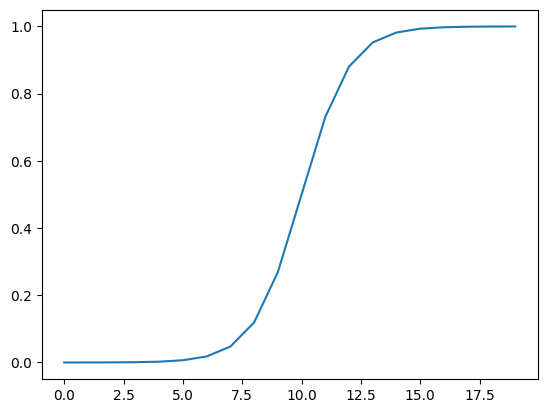

In [113]:
# Plot aour toy tensor transformed by sigmoid function
plt.plot(sigmoid(A))

In [114]:
# Let's recreate ReLu Function
def relu(x):
  return tf.maximum(0, x)

# Pass our toy tensor to our relu function
relu(A)

<tf.Tensor: shape=(20,), dtype=float64, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6.,
       7., 8., 9.])>

In [115]:
A

<tf.Tensor: shape=(20,), dtype=float64, numpy=
array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])>

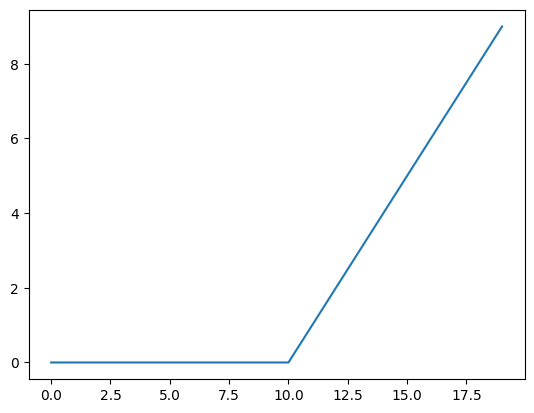

In [118]:
# Plot the relu function result
plt.plot(relu(A))

In [120]:
# Let's try linear activation function
def linear(x):
  return x

In [121]:
linear(A)

<tf.Tensor: shape=(20,), dtype=float64, numpy=
array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])>

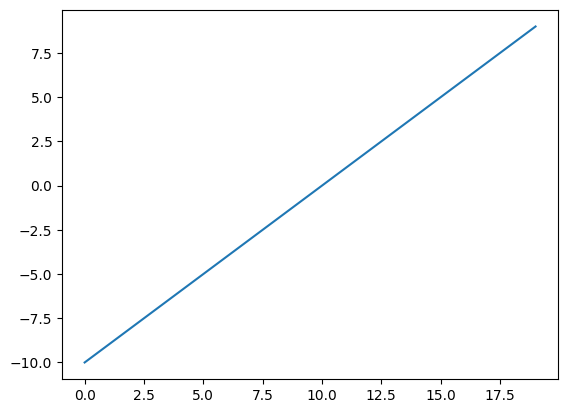

In [124]:
# Does the linear activation function change anything?
plt.plot(tf.keras.activations.linear(A))

In [129]:
# Does anything changed?
A == tf.keras.activations.linear(A)

<tf.Tensor: shape=(20,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])>

See the cheatsheet for activation functions:

https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html